In [1]:
using PyPlot
using Base.MathConstants
using QuadGK
using BenchmarkTools
import Polynomials

## Real Values

Same polynomial generation as before, but this accepts a polynomial to use as the modified approximant.

In [2]:
function E₁_cfpoly_approx(n::Integer, pstart::Polynomials.Poly{T}, ::Type{T}=BigInt) where {T<:Real}
    q = Polynomials.Poly(T[1])
    p = pstart
    x = Polynomials.Poly(T[0,1])
    for i = n:-1:1
        p, q = x*p+(1+i)*q, p # from cf = x + (1+i)/cf = x + (1+i)*q/p
        p, q = p + i*q, p     # from cf = 1 + i/cf = 1 + i*q/p
    end
    # do final 1/(x + inv(cf)) = 1/(x + q/p) = p/(x*p + q)
    return p, x*p + q
end

E₁_cfpoly_approx (generic function with 2 methods)

In [3]:
macro E₁_cf64(x, n::Integer, start)
    pstart = Polynomials.Poly(eval(start))
    # consider using BigFloat?
    p, q = E₁_cfpoly_approx(n, pstart, Float64)
    xesc = esc(x)
    
    num_expr =  :(@evalpoly $xesc)
    append!(num_expr.args, Float64.(Polynomials.coeffs(p)))
    den_expr = :(@evalpoly $xesc)
    append!(den_expr.args, Float64.(Polynomials.coeffs(q)))
    :( exp(-$xesc) * $num_expr / $den_expr )
end

@E₁_cf64 (macro with 1 method)

In [4]:
function E₁_taylor_coefficients(::Type{T}, n::Integer) where {T<:Number}
    n < 0 && throw(ArgumentError("$n ≥ 0 is required"))
    n == 0 && return T[]
    n == 1 && return T[-eulergamma]
    # iteratively compute the terms in the series, starting with k=1
    term::T = 1
    terms = T[-eulergamma, term]
    for k=2:n
        term = -term * (k-1) / (k * k)
        push!(terms, term)
    end
    return terms
end

# inline the Taylor expansion for a given order n, in double precision
macro E₁_taylor64(z, n::Integer)
    c = E₁_taylor_coefficients(Float64, n)
    zesc = esc(z)
    taylor = :(@evalpoly $zesc)
    append!(taylor.args, c)
    :( $taylor - log($zesc) )
end

@E₁_taylor64 (macro with 1 method)

$E_1(x)$ with specially chosen modified approximants for faster convergence

In [5]:
function E₁(x::Float64)
    x < 0 && throw(DomainError(x, "negative argument"))
    if x > 2.15
        x < 3.0   && return @E₁_cf64(x, 18, [6.267445506556548, -2.278962735947262, 0.5577231261815463, -0.05413049191473329])
        x < 4.0   && return @E₁_cf64(x, 16, [5.114292670961982, -1.2789140459431323, 0.22066200334871455, -0.015067049382830766])
        x < 6.1   && return @E₁_cf64(x, 14, [4.194988480897909, -0.7263593325667503, 0.08956574399359891, -0.00434973529065973])
        x < 8.15  && return @E₁_cf64(x, 9,  [3.0362016309948228, -0.33793806630590445, 0.029410409377178114, -0.0010060498260648586])
        x < 25.0  && return @E₁_cf64(x, 8,  [2.5382065303376895, -0.18352177433259526, 0.011141562002742184, -0.0002634921890930066])
        x < 200.0 && return @E₁_cf64(x, 8,  [0.0, 1.0])
        return x < 740.0 ? @E₁_cf64(x, 4, [0.0, 1.0]) : 0.0 # underflow
    else
        # crossover point to taylor could probably be tuned more
        return x ≤ 0.6 ? (x ≤ 0.053 ? (x ≤ 4.4e-3 ? @E₁_taylor64(x,4) :
                                                       @E₁_taylor64(x,8)) :
                                       @E₁_taylor64(x,15)) :
                          @E₁_taylor64(x,37)
    end
end

E₁ (generic function with 1 method)

In [6]:
# for checking implementation
function E₁_slow(z::Union{T,Complex{T}}) where {T<:AbstractFloat}
    real(z) < 0 && error("real(z) < 0 not implemented")
    return quadgk(u -> exp(-z/u)/u, 0, 1, rtol=eps(T)*10)[1]
end
E₁_slow(z::Union{T,Complex{T}}) where {T<:Real} = E₁_slow(float(z))

E₁_slow (generic function with 2 methods)

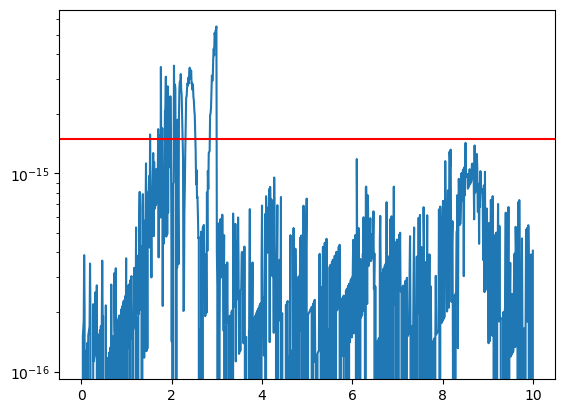

PyObject <matplotlib.lines.Line2D object at 0x14ba3f250>

In [7]:
samples = range(0.01, 10.0, length=1000)
res_slow = E₁_slow.(samples)
res_mine = E₁.(samples)
err = @. abs(res_slow - res_mine) / res_slow

semilogy(samples, err)
axhline(1.5e-15, color="red")

## Complex Values

In [8]:
using SIMD

In [9]:
# pack two polynomial coefficients into SIMD vectors
function pack_coeffs(p1::NTuple{N, T}, p2::NTuple{N, T}) where {N, T}
    arr = Array{Vec{4, T}, 1}(undef, 0)
    for i = 1:N
        # the index N-2 vector of coefficients is modified so that it can also be
        # used as the initial B vector in `evalpolydiv`, to reduce setup time
        idxoff = (i == N-2) ? 1 : 0
        vec = Vec{4, T}((p1[i+idxoff], p1[i], p2[i+idxoff], p2[i]))
        push!(arr, vec)
    end
    return tuple(arr...)
end;

In [10]:
# disassembling this function with @code_native will
# crash julia if @inline is used.
@generated function evalpolydiv(z::Complex, poly::NTuple{N, Vec{4, T}}) where {N, T}
    innerloop = []
    for i = 2:N-2
        insns = quote
            madd = muladd(Avec, RSvec, Bvec)
            Avec = shufflevector(madd, Val(Avec_shuffle_mask))
            Bvec = shufflevector(madd, poly[$(N-i-1)], Val(Bvec_shuffle_mask))
        end
        push!(innerloop, insns)
    end

    Expr(:block,
        quote # setup vectors
            x, y = real(z), imag(z)
            r = 2x
            s = muladd(x, x, y*y)
            # could get rid of one negation instr if LLVM used vfmaddsub
            RSvec = Vec{4, $T}((r, -s, r, -s))
            Avec, Bvec = poly[$N], poly[$N-2]
            madd  = Vec{4, $T}(0)
            Avec_shuffle_mask = (0, 0, 2, 2)
            Bvec_shuffle_mask = (1, 5, 3, 7)
        end,
        innerloop...,
        quote
            # some common subexprs if we complex divide manually.
            # hopefully they are eliminated, should check...
            madd = muladd(Avec, RSvec, Bvec) # one left over from inner loop
            a, b, c, d = madd[1], madd[2], madd[3], madd[4]
            denom = muladd(s*c + 2*d*x, c, d*d)
            numre = muladd(s*c, a, x*(a*d + b*c) + b*d)
            numim = y*(a*d - b*c)
            return Complex(numre/denom, numim/denom)
        end
    )
end;

In [11]:
macro E₁_cf64_simd(z, n::Integer)
    p, q = E₁_cfpoly_approx(n, Polynomials.Poly(BigInt[0,1]), BigInt)
    num_coeffs = Float64.(Polynomials.coeffs(p))
    den_coeffs = Float64.(Polynomials.coeffs(q))
    if length(num_coeffs) < length(den_coeffs)
        push!(num_coeffs, 0)
    end
    
    packed = pack_coeffs(tuple(num_coeffs...), tuple(den_coeffs...))
    zesc = esc(z)
    quote
        exp(-$zesc) * evalpolydiv($zesc, $packed)
    end
end

@E₁_cf64_simd (macro with 1 method)

In [12]:
function E₁(z::Complex{Float64})
    x² = real(z)^2
    y² = imag(z)^2
    if x² + 0.233*y² ≥ 7.84 # use cf expansion, ≤ 30 terms
        if (x² ≥ 546121) & (real(z) > 0) # underflow
            return zero(z)
        elseif x² + 0.401*y² ≥ 58.0 # ≤ 15 terms
            if x² + 0.649*y² ≥ 540.0 # ≤ 8 terms
                x² + y² ≥ 4e4 && return @E₁_cf64_simd(z, 4)
                return @E₁_cf64_simd(z, 8)
            end
            return @E₁_cf64_simd(z, 15)
        end
        return @E₁_cf64_simd(z, 30)
    else # use Taylor expansion, ≤ 37 terms
        r² = x² + y²
        return r² ≤ 0.36 ? (r² ≤ 2.8e-3 ? (r² ≤ 2e-7 ? @E₁_taylor64(z,4) :
                                                       @E₁_taylor64(z,8)) :
                                         @E₁_taylor64(z,15)) :
                          @E₁_taylor64(z,37)
    end
end

E₁ (generic function with 2 methods)

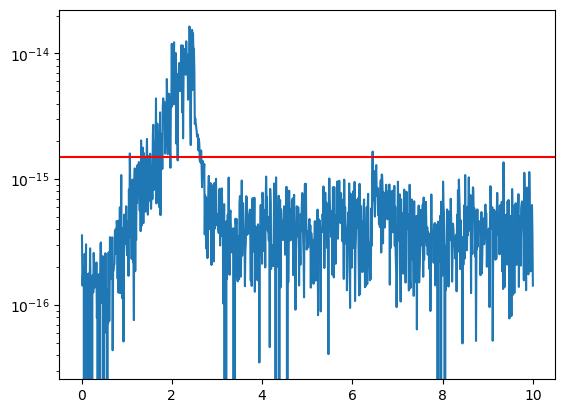

PyObject <matplotlib.lines.Line2D object at 0x159620710>

In [13]:
samples = [x + x*im for x in range(0.01, 10.0, length=1000)]
res_slow = E₁_slow.(samples)
res_mine = E₁.(samples)
err = @. abs(res_slow - res_mine) / abs(res_slow)

semilogy(samples, err)
axhline(1.5e-15, color="red")

In [16]:
Z=3.5+3.5im
@benchmark E₁($Z) samples=100_000

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     65.779 ns (0.00% GC)
  median time:      70.489 ns (0.00% GC)
  mean time:        75.852 ns (0.00% GC)
  maximum time:     270.605 ns (0.00% GC)
  --------------
  samples:          67509
  evals/sample:     964

In [17]:
Z=3.5
@benchmark E₁($Z) samples=100_100

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     16.931 ns (0.00% GC)
  median time:      17.419 ns (0.00% GC)
  mean time:        18.740 ns (0.00% GC)
  maximum time:     123.986 ns (0.00% GC)
  --------------
  samples:          100100
  evals/sample:     996